#IMPORTATION DES DONNEES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.cluster import KMeans

In [3]:
#Importation du fichier de données post scrapping
#PRENDRE LE FICHIER AU FORMAT CSV

from google.colab import files
files.upload()

Saving donnees_python.csv to donnees_python.csv


{'donnees_python.csv': b',Market Cap (intraday) ,Enterprise Value ,Trailing P/E ,Forward P/E ,PEG Ratio (5 yr expected) ,Price/Sales (ttm),Price/Book (mrq),Enterprise Value/Revenue ,Enterprise Value/EBITDA ,Beta (5Y Monthly) ,52-Week Change 3,S&P500 52-Week Change 3,52 Week High 3,52 Week Low 3,50-Day Moving Average 3,200-Day Moving Average 3,Avg Vol (3 month) 3,Avg Vol (10 day) 3,Shares Outstanding 5,Implied Shares Outstanding 6,Float 8,% Held by Insiders 1,% Held by Institutions 1,"Shares Short (Nov 29, 2021) 4","Short Ratio (Nov 29, 2021) 4","Short % of Float (Nov 29, 2021) 4","Short % of Shares Outstanding (Nov 29, 2021) 4","Shares Short (prior month Oct 28, 2021) 4",Forward Annual Dividend Rate 4,Forward Annual Dividend Yield 4,Trailing Annual Dividend Rate 3,Trailing Annual Dividend Yield 3,5 Year Average Dividend Yield 4,Payout Ratio 4,Dividend Date 3,Ex-Dividend Date 4,Last Split Factor 2,Last Split Date 3,Fiscal Year Ends ,Most Recent Quarter (mrq),Profit Margin ,Operating Mar

In [4]:
#Lecture du fichier et visualisation du dataframe

df_données = pd.read_csv('donnees_python.csv')
df_données


,Unnamed: 0,Market Cap (intraday),Enterprise Value,Trailing P/E,Forward P/E,PEG Ratio (5 yr expected),Price/Sales (ttm),Price/Book (mrq),Enterprise Value/Revenue,Enterprise Value/EBITDA,Beta (5Y Monthly),52-Week Change 3,S&P500 52-Week Change 3,52 Week High 3,52 Week Low 3,50-Day Moving Average 3,200-Day Moving Average 3,Avg Vol (3 month) 3,Avg Vol (10 day) 3,Shares Outstanding 5,Implied Shares Outstanding 6,Float 8,% Held by Insiders 1,% Held by Institutions 1,"Shares Short (Nov 29, 2021) 4","Short Ratio (Nov 29, 2021) 4","Short % of Float (Nov 29, 2021) 4","Short % of Shares Outstanding (Nov 29, 2021) 4","Shares Short (prior month Oct 28, 2021) 4",Forward Annual Dividend Rate 4,Forward Annual Dividend Yield 4,Trailing Annual Dividend Rate 3,Trailing Annual Dividend Yield 3,5 Year Average Dividend Yield 4,Payout Ratio 4,Dividend Date 3,Ex-Dividend Date 4,Last Split Factor 2,Last Split Date 3,Fiscal Year Ends,...,"Shares Short (Oct 14, 2021) 4","Short Ratio (Oct 14, 2021) 4","Short % of Float (Oct 14, 2021) 4","Short % of Shares Outstanding (Oct 14, 2021) 4","Shares Short (prior month Sep 14, 2021) 4","Shares Short (Apr 14, 2021) 4","Short Ratio (Apr 14, 2021) 4","Short % of Float (Apr 14, 2021) 4","Short % of Shares Outstanding (Apr 14, 2021) 4","Shares Short (prior month Mar 14, 2021) 4","Shares Short (Aug 30, 2021) 4","Short Ratio (Aug 30, 2021) 4","Short % of Float (Aug 30, 2021) 4","Short % of Shares Outstanding (Aug 30, 2021) 4","Shares Short (prior month Jul 29, 2021) 4","Shares Short (Oct 28, 2021) 4","Short Ratio (Oct 28, 2021) 4","Short % of Float (Oct 28, 2021) 4","Short % of Shares Outstanding (Oct 28, 2021) 4","Shares Short (prior month Sep 29, 2021) 4","Shares Short (Sep 29, 2021) 4","Short Ratio (Sep 29, 2021) 4","Short % of Float (Sep 29, 2021) 4","Short % of Shares Outstanding (Sep 29, 2021) 4","Shares Short (prior month Aug 30, 2021) 4","Shares Short (Jul 14, 2021) 4","Short Ratio (Jul 14, 2021) 4","Short % of Float (Jul 14, 2021) 4","Short % of Shares Outstanding (Jul 14, 2021) 4","Shares Short (prior month Jun 14, 2021) 4","Shares Short (Jun 29, 2021) 4","Short Ratio (Jun 29, 2021) 4","Short % of Float (Jun 29, 2021) 4","Short % of Shares Outstanding (Jun 29, 2021) 4","Shares Short (prior month May 27, 2021) 4","Shares Short (Apr 29, 2021) 4","Short Ratio (Apr 29, 2021) 4","Short % of Float (Apr 29, 2021) 4","Short % of Shares Outstanding (Apr 29, 2021) 4","Shares Short (prior month Mar 30, 2021) 4"
0,AAPL,2.94T,3.01T,31.99,32.05,3.85,8.27,46.67,8.22,24.41,1.20,33.46%,25.05%,182.13,116.21,156.34,141.48,89.17M,133.84M,16.41B,NaN,16.39B,0.07%,58.79%,112.6M,1.40,0.69%,0.69%,100.5M,0.88,0.51%,0.85,0.50%,1.20,15.15%,"Nov 10, 2021","Nov 04, 2021",4:1,"Aug 30, 2020","Sep 24, 2021",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MSFT,2.57T,2.50T,38.32,37.45,2.91,14.75,16.92,14.21,27.81,0.87,45.47%,25.05%,349.67,211.94,325.68,282.93,26.63M,33.76M,7.51B,NaN,7.5B,0.07%,71.84%,40.88M,1.68,0.54%,0.54%,49.33M,2.48,0.77%,2.30,0.71%,1.42,25.06%,"Mar 09, 2022","Feb 15, 2022",2:1,"Feb 17, 2003","Jun 29, 2021",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NVDA,754.95B,747.48B,93.06,58.82,3.22,31.51,31.72,30.79,75.30,1.37,108.52%,25.05%,346.47,115.67,278.43,203.24,40.22M,60.89M,2.49B,NaN,2.4B,4.08%,66.82%,22.55M,0.44,0.94%,0.90%,26.11M,0.16,0.06%,0.16,0.06%,0.26,4.93%,"Dec 22, 2021","Nov 30, 2021",4:1,"Jul 19, 2021","Jan 30, 2021",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TSM,567.15B,553.17B,30.20,25.38,1.89,11.31,8.23,0.37,0.53,1.00,10.96%,25.05%,142.20,102.91,117.30,116.97,7.82M,7.07M,5.19B,NaN,4.84B,0.01%,17.27%,13.06M,1.47,NaN,0.25%,12.34M,1.93,1.66%,10.75,9.24%,2.81,

#Sélection des variables d'intérêt et préparation du dataframe (1ère partie du preprocessing)

In [5]:
#On sélectionne un subset du dataframe avec les colonnes les plus intéressantes pour notre analyse 

columns_analysis = ['Trailing P/E ','PEG Ratio (5 yr expected) ','Enterprise Value/Revenue ','Enterprise Value/EBITDA ','Profit Margin ','Operating Margin (ttm)','Return on Assets (ttm)','Return on Equity (ttm)','Revenue (ttm)','Revenue Per Share (ttm)','Gross Profit (ttm)','EBITDA ','Total Cash Per Share (mrq)','Total Debt/Equity (mrq)','Current Ratio (mrq)','Levered Free Cash Flow (ttm)']
df_selected = df_données[columns_analysis]
df_selected

,Trailing P/E,PEG Ratio (5 yr expected),Enterprise Value/Revenue,Enterprise Value/EBITDA,Profit Margin,Operating Margin (ttm),Return on Assets (ttm),Return on Equity (ttm),Revenue (ttm),Revenue Per Share (ttm),Gross Profit (ttm),EBITDA,Total Cash Per Share (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Levered Free Cash Flow (ttm)
0,31.99,3.85,8.22,24.41,25.88%,29.78%,20.18%,147.44%,365.82B,21.90,152.84B,120.23B,3.82,216.39,1.08,73.3B
1,38.32,2.91,14.21,27.81,38.51%,42.14%,14.59%,49.30%,176.25B,23.40,115.86B,85.75B,17.39,51.94,2.16,49.82B
2,93.06,3.22,30.79,75.30,33.81%,35.45%,15.93%,41.94%,24.27B,9.75,10.56B,9.76B,7.72,49.70,7.14,5.94B
3,30.20,1.89,0.37,0.53,37.93%,41.34%,13.08%,29.67%,1.51T,291.31,711.15B,1.03T,190.8,29.12,2.09,103.62B
4,52.21,1.81,17.86,47.70,30.54%,34.83%,14.76%,43.26%,17.88B,43.31,6.8B,6.6B,10.92,35.69,1.71,6.56B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NaN,NaN,NaN,NaN,-95.40%,-68.43%,-9.70%,-194.51%,1.33B,4.60,774.09M,-789.31M,4.73,"1,328.39",3.04,-331.37M
501,NaN,NaN,NaN,NaN,10.27%,12.86%,4.26%,9.00%,3.17B,30.25,1.22B,683.12M,14.7,37.04,2.97,275.67M
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df_selected = df_selected.astype(str)
columns_names = list(df_selected)

#On observe que le dataframe contient des valeurs contenant des caractères (tels que %,B,M,...) bloquant la conversion en format float 
#On remplace donc les caractères indésirables

for c in columns_names :
  df_selected.replace(regex=[','], value='',inplace=True)
  if df_selected[c].str.contains('%').any() :
    df_selected[c] = df_selected[c] = np.where(df_selected[c].str.contains("%"),df_selected[c].map(lambda x : 0.01*float(str(x).replace("%","")) if ("%" in str(x)) else x),df_selected[c])
  if df_selected[c].str.contains('k').any() :
    df_selected[c] = df_selected[c] = np.where(df_selected[c].str.contains("k"),df_selected[c].map(lambda x : 1000*float(str(x).replace("k","")) if ("k" in str(x)) else x),df_selected[c])
  if df_selected[c].str.contains('M').any() :
    df_selected[c] = df_selected[c] = np.where(df_selected[c].str.contains("M"),df_selected[c].map(lambda x : 1000000*float(str(x).replace("M","")) if ("M" in str(x)) else x),df_selected[c])
  if df_selected[c].str.contains('B').any() :
    df_selected[c] = df_selected[c] = np.where(df_selected[c].str.contains("B"),df_selected[c].map(lambda x : 1000000000*float(str(x).replace("B","")) if ("B" in str(x)) else x),df_selected[c])
  if df_selected[c].str.contains('T').any() :
    df_selected[c] = df_selected[c] = np.where(df_selected[c].str.contains("T"),df_selected[c].map(lambda x : 1000000000000*float(str(x).replace("T","")) if ("T" in str(x)) else x),df_selected[c])
df_selected

,Trailing P/E,PEG Ratio (5 yr expected),Enterprise Value/Revenue,Enterprise Value/EBITDA,Profit Margin,Operating Margin (ttm),Return on Assets (ttm),Return on Equity (ttm),Revenue (ttm),Revenue Per Share (ttm),Gross Profit (ttm),EBITDA,Total Cash Per Share (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Levered Free Cash Flow (ttm)
0,31.99,3.85,8.22,24.41,0.2588,0.2978,0.2018,1.4744,3.6582e+11,21.90,1.5284e+11,1.2023e+11,3.82,216.39,1.08,7.33e+10
1,38.32,2.91,14.21,27.81,0.3851,0.4214,0.1459,0.493,1.7625e+11,23.40,1.1586e+11,8.575e+10,17.39,51.94,2.16,4.982e+10
2,93.06,3.22,30.79,75.30,0.3381,0.3545,0.1593,0.4194,2.427e+10,9.75,1.056e+10,9.76e+09,7.72,49.70,7.14,5.94e+09
3,30.20,1.89,0.37,0.53,0.3793,0.4134,0.1308,0.2967,1.51e+12,291.31,7.1115e+11,1.03e+12,190.8,29.12,2.09,1.0362e+11
4,52.21,1.81,17.86,47.70,0.3054,0.3483,0.1476,0.4326,1.788e+10,43.31,6.8e+09,6.6e+09,10.92,35.69,1.71,6.56e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,nan,nan,nan,nan,-0.954,-0.6843,-0.097,-1.9451,1.33e+09,4.60,7.7409e+08,-7.8931e+08,4.73,1328.39,3.04,-3.3137e+08
501,nan,nan,nan,nan,0.1027,0.1286,0.0426,0.09,3.17e+09,30.25,1.22e+09,6.8312e+08,14.7,37.04,2.97,2.7567e+08
502,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
503,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [7]:
df_selected = df_selected.astype(float) #On converti l'ensemble des données sous type float
df_selected

,Trailing P/E,PEG Ratio (5 yr expected),Enterprise Value/Revenue,Enterprise Value/EBITDA,Profit Margin,Operating Margin (ttm),Return on Assets (ttm),Return on Equity (ttm),Revenue (ttm),Revenue Per Share (ttm),Gross Profit (ttm),EBITDA,Total Cash Per Share (mrq),Total Debt/Equity (mrq),Current Ratio (mrq),Levered Free Cash Flow (ttm)
0,31.99,3.85,8.22,24.41,0.2588,0.2978,0.2018,1.4744,3.658200e+11,21.90,1.528400e+11,1.202300e+11,3.82,216.39,1.08,7.330000e+10
1,38.32,2.91,14.21,27.81,0.3851,0.4214,0.1459,0.4930,1.762500e+11,23.40,1.158600e+11,8.575000e+10,17.39,51.94,2.16,4.982000e+10
2,93.06,3.22,30.79,75.30,0.3381,0.3545,0.1593,0.4194,2.427000e+10,9.75,1.056000e+10,9.760000e+09,7.72,49.70,7.14,5.940000e+09
3,30.20,1.89,0.37,0.53,0.3793,0.4134,0.1308,0.2967,1.510000e+12,291.31,7.111500e+11,1.030000e+12,190.80,29.12,2.09,1.036200e+11
4,52.21,1.81,17.86,47.70,0.3054,0.3483,0.1476,0.4326,1.788000e+10,43.31,6.800000e+09,6.600000e+09,10.92,35.69,1.71,6.560000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,NaN,NaN,NaN,NaN,-0.9540,-0.6843,-0.0970,-1.9451,1.330000e+09,4.60,7.740900e+08,-7.893100e+08,4.73,1328.39,3.04,-3.313700e+08
501,NaN,NaN,NaN,NaN,0.1027,0.1286,0.0426,0.0900,3.170000e+09,30.25,1.220000e+09,6.831200e+08,14.70,37.04,2.97,2.756700e+08
502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
503,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Notre objectif est d'effectuer un clustering par KMeans
#On réduit donc le nombre de dimensions afin d'éviter d'avoir des données trop dispersées

print(list(df_selected))
selec = ['Trailing P/E ','PEG Ratio (5 yr expected) ','Levered Free Cash Flow (ttm)','Total Debt/Equity (mrq)']
df_restricted = df_selected[selec]

['Trailing P/E ', 'PEG Ratio (5 yr expected) ', 'Enterprise Value/Revenue ', 'Enterprise Value/EBITDA ', 'Profit Margin ', 'Operating Margin (ttm)', 'Return on Assets (ttm)', 'Return on Equity (ttm)', 'Revenue (ttm)', 'Revenue Per Share (ttm)', 'Gross Profit (ttm)', 'EBITDA ', 'Total Cash Per Share (mrq)', 'Total Debt/Equity (mrq)', 'Current Ratio (mrq)', 'Levered Free Cash Flow (ttm)']


#Analyse descriptive

In [9]:
#On va procéder à une analyse descriptive avant de modifier numériquement nos données
df_restricted.describe()

#On observe que les données ne sont ni centrées ni normalisées
#On va donc utiliser StandardScaler plus loin pour résoudre ce problème

,Trailing P/E,PEG Ratio (5 yr expected),Levered Free Cash Flow (ttm),Total Debt/Equity (mrq)
count,142.000000,116.000000,3.950000e+02,435.000000
mean,125.588451,5.194397,1.104112e+10,303.281931
std,407.089284,24.403798,1.439160e+11,3415.688556
min,0.900000,0.330000,-2.720000e+09,0.050000
25%,23.047500,1.377500,3.386500e+07,10.645000
50%,36.110000,2.190000,1.351000e+08,42.600000
75%,74.632500,3.205000,5.221350e+08,94.365000
max,3190.000000,261.450000,2.750000e+12,69456.250000


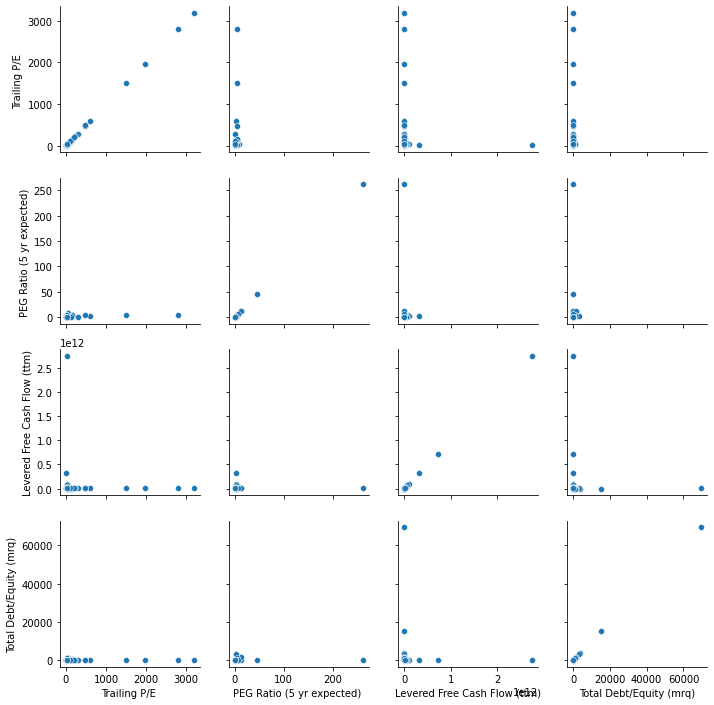

In [10]:
gr = sns.PairGrid(df_restricted,vars = selec)
gr.map(sns.scatterplot)

#On observe que les indicateurs financiers des entreprises sélectionnées sont très similaires
#On peut donc prévoir un cluster majoritaire avec un ou plusieurs clusters à côté beaucoup plus petits en taille

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Coefficient d'asymétrie Trailing P/E: 6.064360305937859 
Coefficient d'asymétrie Levered Free Cash Flow: 17.917455804419532 


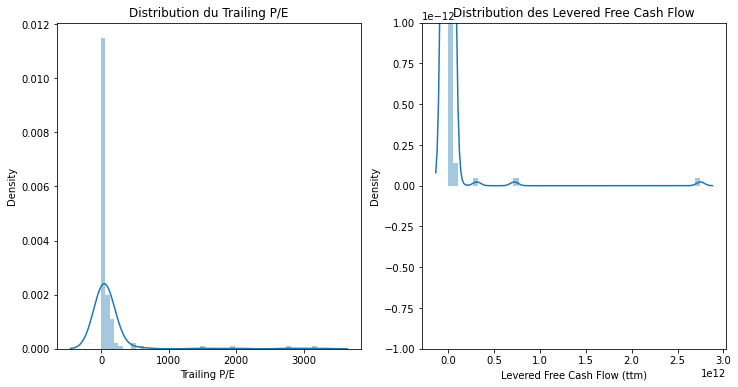

In [11]:
#Distribution des Trailing P/E et des Levered Free Cash Flow

fig, axes = plt.subplots(1, 2, figsize = (12,6))
sns.distplot(df_restricted['Trailing P/E '], ax = axes[0]).set_title('Distribution du Trailing P/E')
sns.distplot(df_restricted['Levered Free Cash Flow (ttm)'], ax = axes[1]).set_title('Distribution des Levered Free Cash Flow')

#On observe que les valeurs sont très regroupées autour de 0 avec pas ou peu de valeurs extrêmes

print("Coefficient d'asymétrie Trailing P/E: {} ".format(df_restricted['Trailing P/E '].skew()))
print("Coefficient d'asymétrie Levered Free Cash Flow: {} ".format(df_restricted['Levered Free Cash Flow (ttm)'].skew()))

#Les données sont plutôt symétriques (autour de 0)

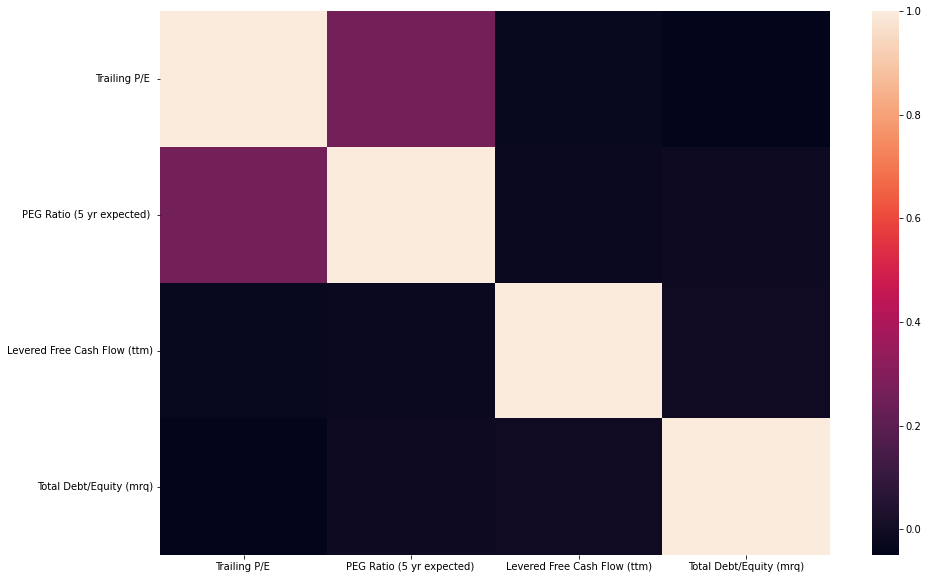

In [12]:
#On étudie la corrélation des variables entre elles
#KMeans sera d'autant plus efficace que les features ne sont pas correlées entre elles

mat_corr= df_restricted.corr()
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(mat_corr)

#Le résultat est satisfaisant : les quatres features que l'on a sélectionné se montrent être presque totalement décorelées les unes des autres

#Data preprocessing (partie 2)

In [13]:
#Centering and normalizing data :

from sklearn.preprocessing import StandardScaler

scaled_features = StandardScaler().fit_transform(df_restricted.values)
scaled_features_df = pd.DataFrame(scaled_features, index=df_restricted.index, columns=df_restricted.columns)
scaled_features_df.describe()

,Trailing P/E,PEG Ratio (5 yr expected),Levered Free Cash Flow (ttm),Total Debt/Equity (mrq)
count,1.420000e+02,1.160000e+02,3.950000e+02,4.350000e+02
mean,-3.537859e-17,-1.196361e-18,5.270924e-17,6.061562e-19
std,1.003540e+00,1.004338e+00,1.001268e+00,1.001151e+00
min,-3.073769e-01,-2.001943e-01,-9.574040e-02,-8.887844e-02
25%,-2.527798e-01,-1.570844e-01,-7.658091e-02,-8.577301e-02
50%,-2.205786e-01,-1.236460e-01,-7.587659e-02,-7.640687e-02
75%,-1.256145e-01,-8.187362e-02,-7.318387e-02,-6.123435e-02
max,7.554262e+00,1.054620e+01,1.905578e+01,2.026900e+01


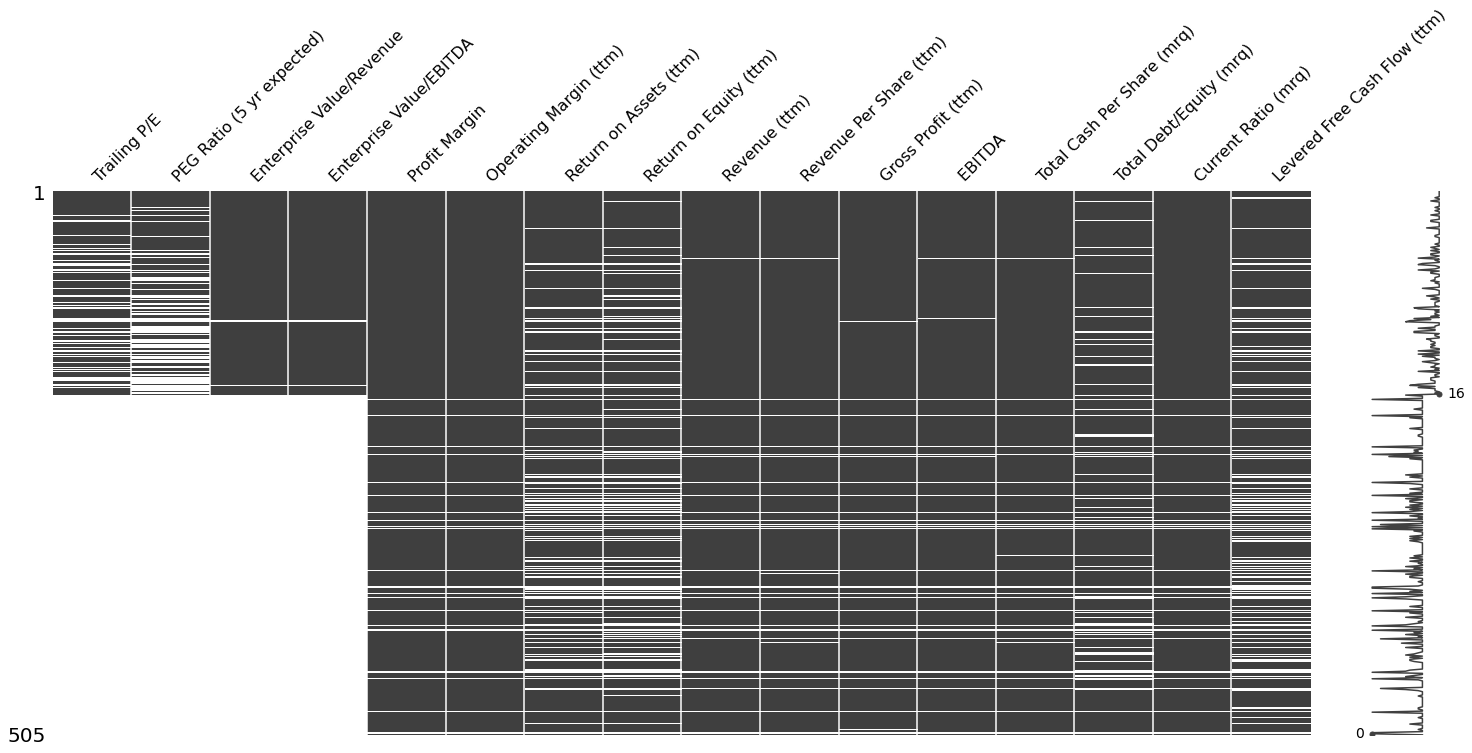

In [14]:
df_restricted = scaled_features_df.copy()
missingno.matrix(df_selected);

#On observe que les valeurs manquantes sont nombreuses
#KMeans ne peut pas prendre ce type de valeur en entrée
#On décide donc de les remplacer par la médiane de chaque colonne dans la suite

In [15]:
df_restricted.fillna(df_restricted.median(),inplace=True)
df_restricted

,Trailing P/E,PEG Ratio (5 yr expected),Levered Free Cash Flow (ttm),Total Debt/Equity (mrq)
0,-0.230735,-0.055329,0.433154,-0.025468
1,-0.215131,-0.094014,0.269797,-0.073669
2,-0.080188,-0.081256,-0.035490,-0.074326
3,-0.235148,-0.135992,0.644100,-0.080358
4,-0.180890,-0.139285,-0.031177,-0.078432
...,...,...,...,...
500,-0.220579,-0.123646,-0.079122,0.300463
501,-0.220579,-0.123646,-0.074899,-0.078037
502,-0.220579,-0.123646,-0.075877,-0.076407
503,-0.220579,-0.123646,-0.075877,-0.076407


#Clustering

**IMPORTANT** : le but du clustering ci dessous n'est pas  

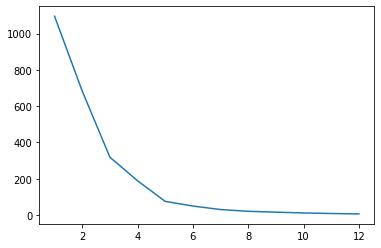

In [16]:
#On détermine le nombre optimal de clusters
#Pour ce faire, on utilise la méthode du coude
#Le nombre de cluster à choisir est donné par l'abscisse du point de cassure de la courbe

Y = df_restricted.iloc[:,:].values
L = []
for i in range (1,13):
  kmeans = KMeans(n_clusters=i)
  kmeans.fit(Y)
  L.append(kmeans.inertia_)

plt.plot(range(1,13),L)
plt.show()

#Ici on observe que le nombre de clusters est 4

In [17]:
#On labelise alors les données

kmeans = KMeans(n_clusters=4).fit(Y)
labels = kmeans.labels_
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [18]:
#Attribution des labels

df_restricted['Labels'] = labels
df_restricted

,Trailing P/E,PEG Ratio (5 yr expected),Levered Free Cash Flow (ttm),Total Debt/Equity (mrq),Labels
0,-0.230735,-0.055329,0.433154,-0.025468,0
1,-0.215131,-0.094014,0.269797,-0.073669,0
2,-0.080188,-0.081256,-0.035490,-0.074326,0
3,-0.235148,-0.135992,0.644100,-0.080358,0
4,-0.180890,-0.139285,-0.031177,-0.078432,0
...,...,...,...,...,...
500,-0.220579,-0.123646,-0.079122,0.300463,0
501,-0.220579,-0.123646,-0.074899,-0.078037,0
502,-0.220579,-0.123646,-0.075877,-0.076407,0
503,-0.220579,-0.123646,-0.075877,-0.076407,0


In [19]:
#Sortie des clusters d'entreprises

stock_symbols = df_données['Unnamed: 0']
df_restricted['Stock_Symbols'] = stock_symbols

cluster_1 = list(df_restricted[df_restricted['Labels']==0]['Stock_Symbols'])
print(cluster_1)
cluster_2 = list(df_restricted[df_restricted['Labels']==1]['Stock_Symbols'])
print(cluster_2)
cluster_3 = list(df_restricted[df_restricted['Labels']==2]['Stock_Symbols'])
print(cluster_3)
cluster_4 = list(df_restricted[df_restricted['Labels']==3]['Stock_Symbols'])
print(cluster_4)



['AAPL', 'MSFT', 'NVDA', 'TSM', 'ASML', 'AVGO', 'ADBE', 'ACN', 'CSCO', 'ORCL', 'CRM', 'INTC', 'QCOM', 'INTU', 'TXN', 'SHOP', 'AMD', 'SAP', 'AMAT', 'NOW', 'IBM', 'SNOW', 'INFY', 'LRCX', 'MU', 'ADI', 'TEAM', 'UBER', 'SQ', 'MRVL', 'FISV', 'FIS', 'COIN', 'ADSK', 'ZM', 'KLAC', 'NXPI', 'FTNT', 'SNPS', 'PANW', 'TEL', 'WIT', 'CDNS', 'VMW', 'XLNX', 'APH', 'CRWD', 'MCHP', 'CTSH', 'MSI', 'ZS', 'STM', 'NET', 'ANET', 'DELL', 'U', 'HPQ', 'PLTR', 'EPAM', 'ERIC', 'KEYS', 'OKTA', 'ANSS', 'NOK', 'APP', 'GFS', 'HUBS', 'GLW', 'ZBRA', 'DOCU', 'DIDI', 'UMC', 'AFRM', 'VRSN', 'CAJ', 'ON', 'FTV', 'TER', 'CDW', 'IT', 'BILL', 'GRMN', 'SWKS', 'PAYC', 'STX', 'MPWR', 'PATH', 'GIB', 'TRMB', 'TYL', 'BR', 'SSNC', 'NTAP', 'XM', 'TDY', 'HPE', 'UI', 'AKAM', 'NICE', 'RNG', 'NUAN', 'ENTG', 'SPLK', 'WDC', 'TOST', 'CFLT', 'FLT', 'DT', 'QRVO', 'CLVT', 'ASX', 'NLOK', 'CHKP', 'HOOD', 'ASAN', 'HCP', 'AUR', 'PTC', 'FFIV', 'SEDG', 'LOGI', 'BSY', 'S', 'CGNX', 'LYFT', 'GTLB', 'MNDY', 'BKI', 'OTEX', 'ZEN', 'PCTY', 'JKHY', 'GDDY', 'WO

In [20]:
#Classification des clusters
#On cherche ici à ranger les clusters pour déterminer les "bons" et les "mauvais" investissements potentiels

print(df_restricted[df_restricted['Labels']==0].mean())
print(df_restricted[df_restricted['Labels']==1].mean())
print(df_restricted[df_restricted['Labels']==2].mean())
print(df_restricted[df_restricted['Labels']==3].mean())

#Les données ont été centrées et normalisées au préalable donc les valeurs absolues n'ont plus réel sens cependant l'ordre des indicateurs est conservé, 
#on peut donc toujorus les comparer


#     CONDITIONS :
#Trailing P/E : The lower, the better
#PEG Ratio : The lower, the better
#Levered Free Cash Flow : The higher, the better
#Total Debt.Equity : The lower, the better




score = [0,0,0,0] # Chaque index représente le score d'un cluster (par exemple : score(cluster_1)=score[0] , ...)

#La méthode d'évaluation du score est arbitraire, on ajoute 1 au score du cluster quand sa valeur d'indicateur est meilleure que celle d'un autre cluster (cf conditions données plus haut)


for k in range(4): #On compare chacun des clusters aux autres tour à tour
  for l in range(len(df_restricted[df_restricted['Labels']==k].mean())-1): #On considère les features une à une
    for i in range(4): #On prend la feature en question et on la compare à celle des autres clusters
      if l !=2 : #La condition ici sert à inverser l'ordre de comparaison pour le Levered Free Cash Flow (position 2) (puisqu'on préfère quand il est élevé)
        if df_restricted[df_restricted['Labels']==k].mean().iloc[l]<df_restricted[df_restricted['Labels']==i].mean().iloc[l]:
          score[k]+=1
          print(k,l,i)
          print(score)
      if l ==2 :
        if df_restricted[df_restricted['Labels']==k].mean().iloc[l]>df_restricted[df_restricted['Labels']==i].mean().iloc[l]:
          print(k,l,i)
          score[k]+=1
          print(score)

#Ainsi l'ordre de préférence des clusters est : 

#Cluster_3
#Cluster_1
#Cluster_2
#Cluster_4





Trailing P/E                   -0.203743
PEG Ratio (5 yr expected)      -0.095275
Levered Free Cash Flow (ttm)   -0.054179
Total Debt/Equity (mrq)        -0.050621
Labels                          0.000000
dtype: float64
Trailing P/E                    -0.263768
PEG Ratio (5 yr expected)       -0.123646
Levered Free Cash Flow (ttm)    19.055784
Total Debt/Equity (mrq)         -0.077957
Labels                           1.000000
dtype: float64
Trailing P/E                    -0.220579
PEG Ratio (5 yr expected)       -0.123646
Levered Free Cash Flow (ttm)    -0.075904
Total Debt/Equity (mrq)         20.269000
Labels                           2.000000
dtype: float64
Trailing P/E                    5.520506
PEG Ratio (5 yr expected)      -0.077141
Levered Free Cash Flow (ttm)   -0.072687
Total Debt/Equity (mrq)        -0.069897
Labels                          3.000000
dtype: float64
0 0 3
[1, 0, 0, 0]
0 1 3
[2, 0, 0, 0]
0 2 2
[3, 0, 0, 0]
0 2 3
[4, 0, 0, 0]
0 3 2
[5, 0, 0, 0]
1 0 0
[5, 1, 0,